In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


Found 188 CSV files


Loading datasets:   5%|███▍                                                            | 10/188 [00:00<00:01, 92.09it/s]

detected high steering, skip this set: data_synced/b0c9d2329ad1606b_2018-07-29--11-17-20_4.csv


Loading datasets:  18%|███████████                                                    | 33/188 [00:00<00:01, 102.80it/s]

detected high steering, skip this set: data_synced/b0c9d2329ad1606b_2018-07-29--12-02-42_28.csv
detected high steering, skip this set: data_synced/b0c9d2329ad1606b_2018-07-29--12-02-42_30.csv
detected high steering, skip this set: data_synced/b0c9d2329ad1606b_2018-07-29--16-37-17_5.csv


Loading datasets:  59%|████████████████████████████████████▊                          | 110/188 [00:01<00:00, 88.99it/s]

detected high steering, skip this set: data_synced/b0c9d2329ad1606b_2018-08-03--10-35-16_14.csv


Loading datasets:  94%|███████████████████████████████████████████████████████████▎   | 177/188 [00:01<00:00, 95.26it/s]

detected high steering, skip this set: data_synced/b0c9d2329ad1606b_2018-08-17--12-07-08_37.csv
detected high steering, skip this set: data_synced/b0c9d2329ad1606b_2018-08-17--14-17-47_12.csv
detected high steering, skip this set: data_synced/b0c9d2329ad1606b_2018-08-17--14-17-47_13.csv
detected high steering, skip this set: data_synced/b0c9d2329ad1606b_2018-08-17--14-55-39_1.csv
detected high steering, skip this set: data_synced/b0c9d2329ad1606b_2018-08-17--14-55-39_2.csv
detected high steering, skip this set: data_synced/b0c9d2329ad1606b_2018-08-17--14-55-39_7.csv


Loading datasets: 100%|███████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 91.94it/s]


Found 75 CSV files


Loading datasets:  40%|██████████████████████████                                       | 30/75 [00:00<00:00, 77.15it/s]

detected high steering, skip this set: data_synced_chunk2/b0c9d2329ad1606b_2018-09-13--22-01-21_15.csv


Loading datasets:  91%|██████████████████████████████████████████████████████████▉      | 68/75 [00:00<00:00, 88.35it/s]

detected high steering, skip this set: data_synced_chunk2/b0c9d2329ad1606b_2018-09-21--23-18-39_0.csv


Loading datasets: 100%|█████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 80.34it/s]



Dataset sizes:
Total samples: 211022
Train: 168817 (80.0%)
Validation: 42205 (20.0%)
Test: 87371 (100.0%)

Visualizing sample datapoints from training set...


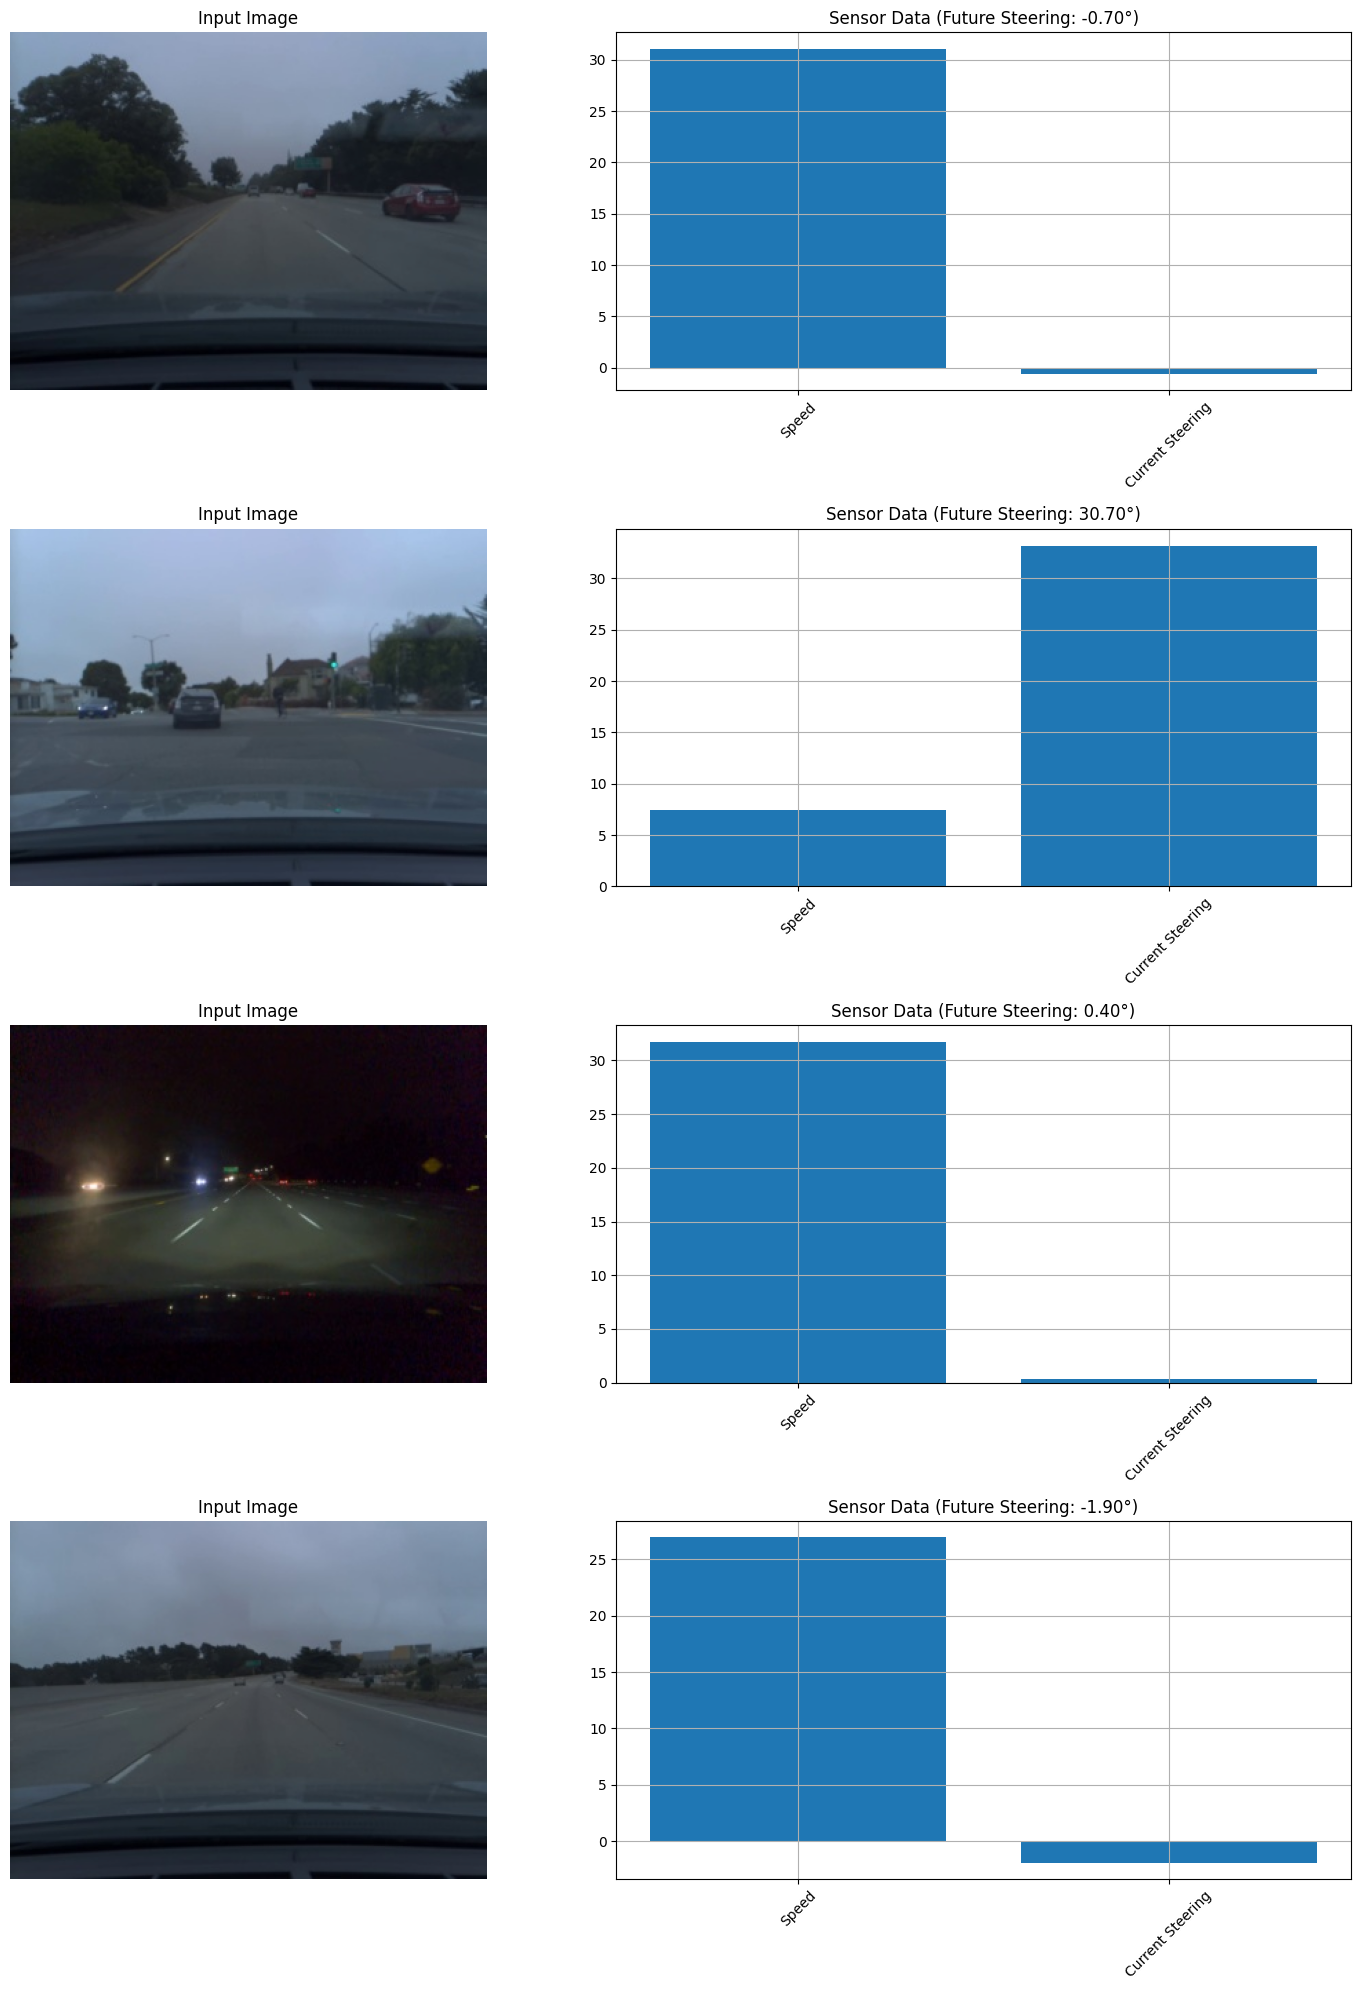

In [2]:
import glob
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset, random_split
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

class DrivingDataset(Dataset):
    def __init__(self, csv_file, data_dir, transform=None):
        # Load the CSV data
        self.data = pd.read_csv(csv_file)
        
        # Get frames directory path from CSV filename
        filename = os.path.basename(csv_file)
        self.frames_dir = os.path.join(data_dir, f"{filename[:-4]}_frames")
        
        # Verify frames directory exists
        if not os.path.exists(self.frames_dir):
            raise FileNotFoundError(f"Frames directory not found: {self.frames_dir}")
        
        self.transform = transform or transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get frame index from data
        frame_idx = int(self.data.iloc[idx]['frame_idx'])
        
        # Load frame image
        frame_path = os.path.join(self.frames_dir, f"{frame_idx}.jpg")
        frame = Image.open(frame_path).convert('RGB')
        
        if self.transform:
            frame = self.transform(frame)
        
        row = self.data.iloc[idx]
        
        # Get current sensor data (inputs)
        speed_value = float(row['speed'].strip('[]') if isinstance(row['speed'], str) else row['speed'])
        
        current_data = torch.tensor([
            speed_value,
            #row['gyro_x'], row['gyro_y'], row['gyro_z'],
            row['current_steering'],
        ], dtype=torch.float32)
        
        # Get future steering angle (target)
        target = torch.tensor(row['future_steering'], dtype=torch.float32)
        
        return frame, current_data, target

def visualize_sample_datapoints(dataset, num_samples=4):
    """
    Visualize a few sample datapoints from the dataset to verify format
    """
    fig, axes = plt.subplots(num_samples, 2, figsize=(15, 5*num_samples))
    
    for i in range(num_samples):
        # Get a random sample
        idx = np.random.randint(len(dataset))
        image, sensor_data, target = dataset[idx]
        
        # Convert image tensor back to displayable format
        img = image.numpy().transpose(1, 2, 0)
        # Denormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        # Plot image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')
        
        # Create sensor data visualization
        sensor_labels = [
            'Speed', 
            #'Gyro X', 'Gyro Y', 'Gyro Z',
            'Current Steering'
        ]
        
        # Plot sensor data as a bar chart
        axes[i, 1].bar(sensor_labels, sensor_data.numpy())
        axes[i, 1].set_title(f'Sensor Data (Future Steering: {target:.2f}°)')
        axes[i, 1].tick_params(axis='x', rotation=45)
        axes[i, 1].grid(True)
    
    plt.tight_layout()
    plt.show()


# -- training --
# Get list of all CSV files in data_synced
train_val_csv_files = [f for f in glob.glob('data_synced/*.csv') if 'combined_dataset.csv' not in f]
print(f"Found {len(train_val_csv_files)} CSV files")

# Create datasets for each segment
training_data_dir = 'data_synced'
train_val_datasets = []
#counter = 0
for csv_file in tqdm(train_val_csv_files, desc="Loading datasets"):
    try:
        #if counter > 10:
            #break
        data_for_large_steer_angle_check = pd.read_csv(csv_file)
        if (((data_for_large_steer_angle_check['future_steering'] > 45).any()) | ((data_for_large_steer_angle_check['future_steering'] < -45).any())):
            print("detected high steering, skip this set:", csv_file)
            continue
        dataset = DrivingDataset(csv_file, training_data_dir)
        train_val_datasets.append(dataset)
        #print(f"Successfully loaded dataset from {csv_file}")
        #counter = counter + 1
    except Exception as e:
        print(f"Error loading {csv_file}: {str(e)}")
        continue

if not train_val_datasets:
    raise RuntimeError("No training datasets were successfully loaded!")

# -- testing --
# Get list of all CSV files in data_synced
testing_csv_files = glob.glob('data_synced_chunk2/*.csv')
print(f"Found {len(testing_csv_files)} CSV files")

# Create datasets for each segment
testing_data_dir = 'data_synced_chunk2'
testing_datasets = []
#counter = 0
for csv_file in tqdm(testing_csv_files, desc="Loading datasets"):
    try:
        #if counter > 10:
            #break
        data_for_large_steer_angle_check = pd.read_csv(csv_file)
        if (((data_for_large_steer_angle_check['future_steering'] > 45).any()) | ((data_for_large_steer_angle_check['future_steering'] < -45).any())):
            print("detected high steering, skip this set:", csv_file)
            continue
        dataset = DrivingDataset(csv_file, testing_data_dir)
        testing_datasets.append(dataset)
        #print(f"Successfully loaded dataset from {csv_file}")
        #counter = counter + 1
    except Exception as e:
        print(f"Error loading {csv_file}: {str(e)}")
        continue

if not testing_datasets:
    raise RuntimeError("No testing datasets were successfully loaded!")

# Combine all datasets
full_train_val_dataset = ConcatDataset(train_val_datasets)
total_train_val_size = len(full_train_val_dataset)

# Split dataset into train, validation(80%, 20%)
total_train_val_len = len(full_train_val_dataset)
train_end = int(0.8 * total_train_val_len) # from 0 to 0.8
val_end = total_train_val_len # from 0.8 to 1

full_testing_dataset = ConcatDataset(testing_datasets)
total_testing_size = len(full_testing_dataset)
total_testing_len = len(full_testing_dataset)

train_dataset = Subset(full_train_val_dataset, list(range(0, train_end))) # from 0 to 8
val_dataset = Subset(full_train_val_dataset, list(range(train_end, val_end))) # from 0.8 to 1
test_dataset = Subset(full_testing_dataset, list(range(0, total_testing_len))) # full testing dataset

print(f"\nDataset sizes:")
print(f"Total samples: {total_train_val_size}")
print(f"Train: {len(train_dataset)} ({len(train_dataset)/total_train_val_size*100:.1f}%)")
print(f"Validation: {len(val_dataset)} ({len(val_dataset)/total_train_val_size*100:.1f}%)")
print(f"Test: {len(test_dataset)} ({len(test_dataset)/total_testing_size*100:.1f}%)")

# Create data loaders with no workers for simplicity
train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=128,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True
)

# Visualize some samples to verify data format
print("\nVisualizing sample datapoints from training set...")
visualize_sample_datapoints(train_dataset)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision.models as models
from torchvision.models import mobilenet_v2

class SteeringAngleCNN(nn.Module):
    def __init__(self):
        super(SteeringAngleCNN, self).__init__()
        mobilenet = mobilenet_v2(pretrained=True)
        self.features = mobilenet.features  # Output shape: [B, 1280, H, W]
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Sequential(
            nn.Linear(1280 + 2, 128),  # 1 = speed + steering angle
            nn.ReLU(),
            nn.Linear(128, 1)          # Predict next steering angle
        )

    def forward(self, image, sensor_data):
        x = self.features(image)            # [B, 1280, H, W]
        x = self.pool(x).view(x.size(0), -1)  # [B, 1280]
        x = torch.cat([x, sensor_data], dim=1)  # [B, 1282]
        return self.fc(x)

In [4]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5):
    """
    Train the model with early stopping.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Add this before training starts
    print("\nGPU Information:")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"Current device: {torch.cuda.current_device()}")
        print(f"Device name: {torch.cuda.get_device_name()}")
        print(f"Device memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    
    model.to(device)
    print(f"Training on {device}")

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # Use tqdm for progress bar
        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
            for images, sensor_data, targets in pbar:
                images = images.to(device)
                sensor_data = sensor_data.to(device)
                targets = targets.to(device).view(-1, 1)  # Future steering angle

                optimizer.zero_grad()
                outputs = model(images, sensor_data)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                pbar.set_postfix({'loss': loss.item()})

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        running_loss = 0.0

        with torch.no_grad():
            for images, sensor_data, targets in val_loader:
                images = images.to(device)
                sensor_data = sensor_data.to(device)
                targets = targets.to(device).view(-1, 1)

                outputs = model(images, sensor_data)
                loss = criterion(outputs, targets)
                running_loss += loss.item() * images.size(0)

        epoch_val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        print ("running loss:", running_loss, "length val loader:", len(val_loader.dataset))
        print(f'Epoch {epoch+1}: Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Load best model
    if best_model is not None:
        model.load_state_dict(best_model)

    # Plot training curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, train_losses, val_losses

In [5]:
def test_model(model, test_loader):
    """
    Test the model with steering-specific metrics for future steering angle prediction.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, sensor_data, target_angle in test_loader:  # Now unpacking three values
            images = images.to(device)
            sensor_data = sensor_data.to(device)
            target_angle = target_angle.to(device).view(-1, 1)  # Future steering angle

            outputs = model(images, sensor_data)
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(target_angle.cpu().numpy())

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Calculate metrics
    mse = np.mean((all_preds - all_targets) ** 2)
    mae = np.mean(np.abs(all_preds - all_targets))
    within_1_deg = np.mean(np.abs(all_preds - all_targets) < 1.0) * 100
    within_3_deg = np.mean(np.abs(all_preds - all_targets) < 3.0) * 100
    within_5_deg = np.mean(np.abs(all_preds - all_targets) < 5.0) * 100

    print("\nTest Results (Predicting Steering Angle at t+200ms):")
    print(f"MSE: {mse:.4f} degrees²")
    print(f"MAE: {mae:.4f} degrees")
    print(f"Predictions within 1°: {within_1_deg:.1f}%")
    print(f"Predictions within 3°: {within_3_deg:.1f}%")
    print(f"Predictions within 5°: {within_5_deg:.1f}%")

    # Visualizations
    plt.figure(figsize=(15, 5))

    # Prediction vs Ground Truth
    plt.subplot(1, 2, 1)
    plt.plot(all_targets[1000:1400], label='Future Ground Truth')
    plt.plot(all_preds[1000:1400], label='Predicted Future')
    plt.xlabel('Sample')
    plt.ylabel('Steering Angle (degrees)')
    plt.title('Predicted vs Actual Future Steering Angles')
    plt.legend()

    # Correlation plot
    plt.subplot(1, 2, 2)
    plt.scatter(all_targets, all_preds, alpha=0.1)
    plt.plot([-45, 45], [-45, 45], 'r--')
    plt.xlabel('Actual Future Steering Angle (degrees)')
    plt.ylabel('Predicted Future Steering Angle (degrees)')
    plt.title('Prediction Correlation (t+200ms)')

    plt.tight_layout()
    plt.show()

/home/langs/tensorflow_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/langs/tensorflow_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Starting training...

GPU Information:
CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 4090
Device memory: 25.76 GB
Training on cuda:0


Epoch 1/10: 100%|███████████████████████████████████████████████████████| 1319/1319 [04:05<00:00,  5.38it/s, loss=0.993]


running loss: 50973.86393585801 length val loader: 42205
Epoch 1: Train Loss: 1.1071, Val Loss: 1.2078


Epoch 2/10: 100%|███████████████████████████████████████████████████████| 1319/1319 [04:01<00:00,  5.46it/s, loss=0.801]


running loss: 41114.925953909755 length val loader: 42205
Epoch 2: Train Loss: 0.5814, Val Loss: 0.9742


Epoch 3/10: 100%|███████████████████████████████████████████████████████| 1319/1319 [04:01<00:00,  5.46it/s, loss=0.583]


running loss: 47122.66968092322 length val loader: 42205
Epoch 3: Train Loss: 0.5546, Val Loss: 1.1165


Epoch 4/10: 100%|███████████████████████████████████████████████████████| 1319/1319 [04:00<00:00,  5.48it/s, loss=0.525]


running loss: 39197.71783751249 length val loader: 42205
Epoch 4: Train Loss: 0.5250, Val Loss: 0.9287


Epoch 5/10: 100%|███████████████████████████████████████████████████████| 1319/1319 [04:00<00:00,  5.47it/s, loss=0.566]


running loss: 37104.85507017374 length val loader: 42205
Epoch 5: Train Loss: 0.4944, Val Loss: 0.8792


Epoch 6/10: 100%|███████████████████████████████████████████████████████| 1319/1319 [04:00<00:00,  5.47it/s, loss=0.496]


running loss: 42172.78127935529 length val loader: 42205
Epoch 6: Train Loss: 0.4600, Val Loss: 0.9992


Epoch 7/10: 100%|███████████████████████████████████████████████████████| 1319/1319 [04:00<00:00,  5.48it/s, loss=0.284]


running loss: 37885.70960903168 length val loader: 42205
Epoch 7: Train Loss: 0.4505, Val Loss: 0.8977


Epoch 8/10: 100%|███████████████████████████████████████████████████████| 1319/1319 [03:59<00:00,  5.50it/s, loss=0.506]


running loss: 40872.91125586629 length val loader: 42205
Epoch 8: Train Loss: 0.4179, Val Loss: 0.9684


Epoch 9/10: 100%|███████████████████████████████████████████████████████| 1319/1319 [04:00<00:00,  5.49it/s, loss=0.307]


running loss: 44222.24638521671 length val loader: 42205
Epoch 9: Train Loss: 0.3762, Val Loss: 1.0478


Epoch 10/10: 100%|██████████████████████████████████████████████████████| 1319/1319 [04:00<00:00,  5.49it/s, loss=0.416]


running loss: 40689.36564794183 length val loader: 42205
Epoch 10: Train Loss: 0.3622, Val Loss: 0.9641


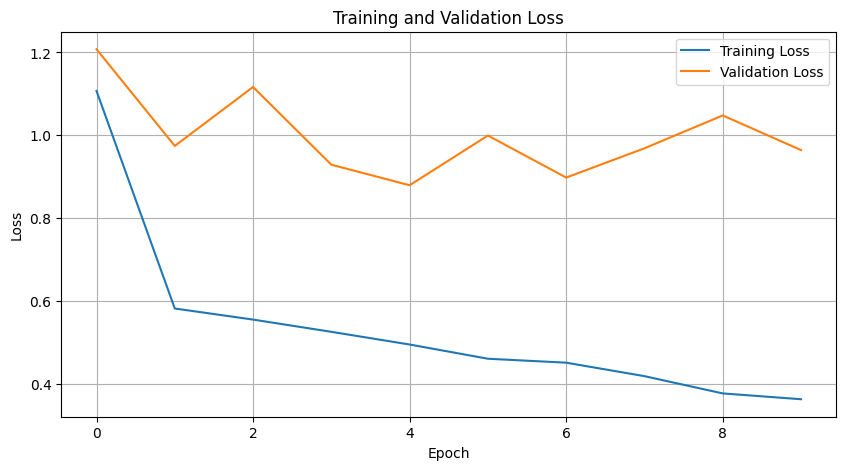


Model saved to 'v4_CNN_MobileNetV2.pth'

Testing the model...

Test Results (Predicting Steering Angle at t+200ms):
MSE: 0.9236 degrees²
MAE: 0.6380 degrees
Predictions within 1°: 80.6%
Predictions within 3°: 98.7%
Predictions within 5°: 99.7%


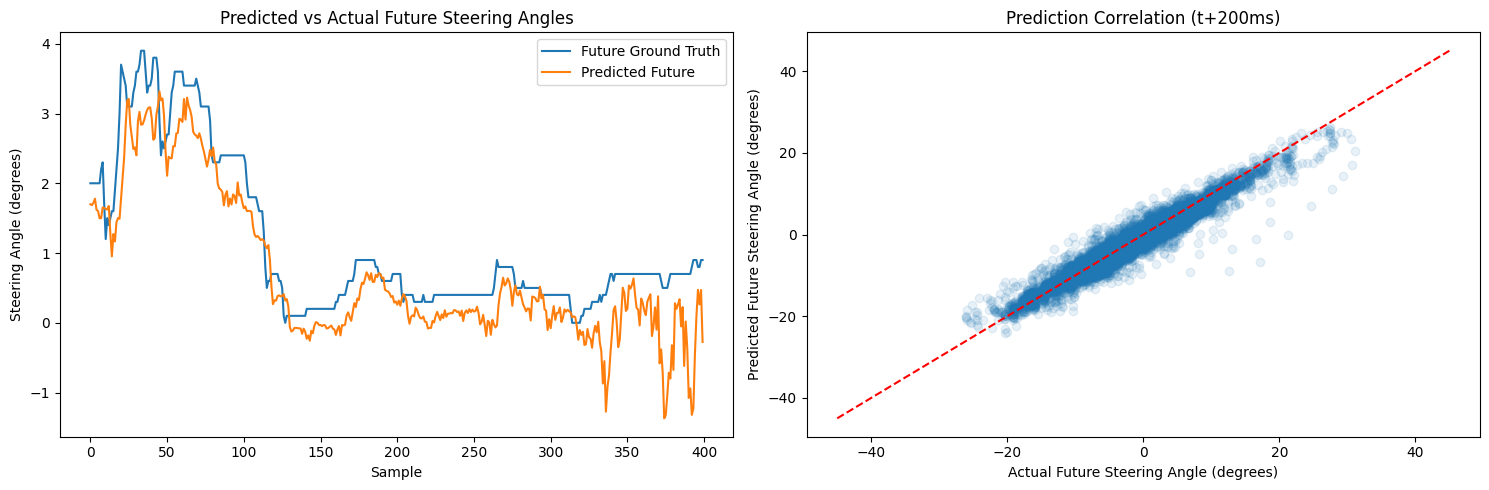


Visualizing some predictions...


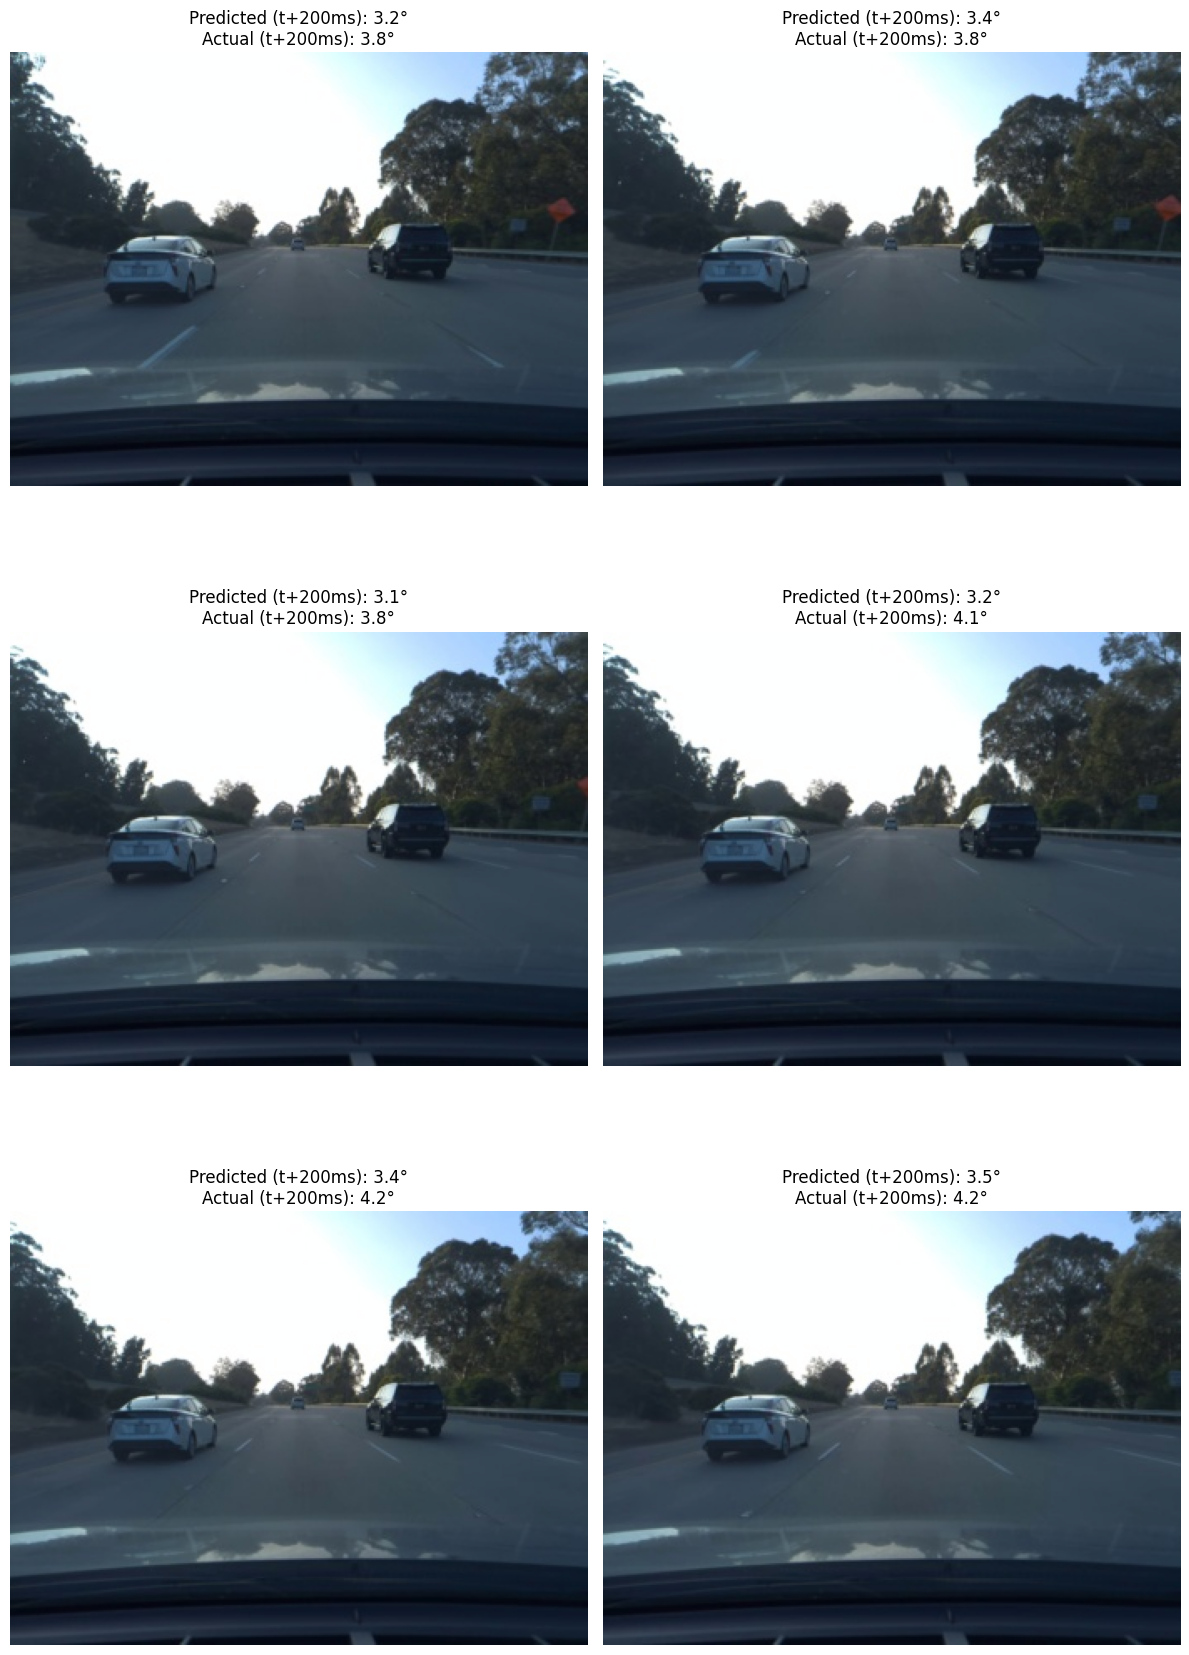

In [6]:
# Initialize and train
model = SteeringAngleCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

print("\nStarting training...")
model, train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,
    patience=6
)

# Save the trained model
torch.save(model.state_dict(), 'v4_CNN_MobileNetV2.pth')
print("\nModel saved to 'v4_CNN_MobileNetV2.pth'")

# Test the model
print("\nTesting the model...")
test_model(model, test_loader)

def visualize_single_batch(model, test_loader):
    model.eval()
    device = next(model.parameters()).device

    # Get a single batch
    images, sensor_data, targets = next(iter(test_loader))
    images = images.to(device)
    sensor_data = sensor_data.to(device)

    with torch.no_grad():
        predictions = model(images, sensor_data)

    # Convert to numpy for visualization
    predictions = predictions.cpu().numpy()
    targets = targets.numpy()

    # Plot a few examples
    fig, axes = plt.subplots(3, 2, figsize=(12, 18))
    for i in range(min(6, len(predictions))):
        ax = axes[i//2, i%2]

        # Get the original image
        img = images[i].cpu().numpy().transpose(1, 2, 0)  # Changed inputs to images

        # Denormalize the image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(f'Predicted (t+200ms): {predictions[i][0]:.1f}°\nActual (t+200ms): {targets[i]:.1f}°')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

print("\nVisualizing some predictions...")
visualize_single_batch(model, test_loader)

In [9]:
def visualize_most_wrong_predictions(model, test_loader, num_worst=18, max_samples=1000):
    model.eval()
    device = next(model.parameters()).device
    
    # Use a heap to keep track of worst predictions
    import heapq
    worst_preds = []
    
    samples_processed = 0
    with torch.no_grad():
        for batch_idx, (images, sensor_data, targets) in enumerate(test_loader):
            batch_size = images.size(0)
            
            # Process in smaller chunks if needed
            for i in range(0, batch_size, 32):
                end = min(i + 32, batch_size)
                img_chunk = images[i:end].to(device)
                sensor_chunk = sensor_data[i:end].to(device)
                target_chunk = targets[i:end]
                
                preds = model(img_chunk, sensor_chunk)
                
                # Move to CPU
                preds = preds.cpu().numpy().squeeze()
                targs = target_chunk.numpy().squeeze()
                
                # Compute errors
                errors = np.abs(preds - targs)
                
                # Store worst predictions using a min heap
                for j in range(len(errors)):
                    error = errors[j]
                    # If we haven't collected enough samples yet or this error is worse than the smallest error in our collection
                    if len(worst_preds) < num_worst or error > worst_preds[0][0]:
                        # Store as (error, img, pred, target)
                        img_data = img_chunk[j].cpu().numpy()
                        if len(worst_preds) >= num_worst:
                            heapq.heappushpop(worst_preds, (error, img_data, preds[j], targs[j]))
                        else:
                            heapq.heappush(worst_preds, (error, img_data, preds[j], targs[j]))
            
            samples_processed += batch_size
            if samples_processed >= max_samples:
                break
    
    # Sort the worst predictions in descending order of error
    worst_preds.sort(reverse=True)
    
    # Plot those images
    fig, axes = plt.subplots(3, 6, figsize=(18, 10)) if num_worst == 18 else plt.subplots(3, 2, figsize=(12, 18))
    for (error, img, pred, target), ax in zip(worst_preds, axes.flat):
        img = img.transpose(1, 2, 0)
        
        # Denormalize image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        ax.set_title(f'Pred: {pred:.1f}° | Actual: {target:.1f}°\nError: {error:.1f}°')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


Testing the model...

Test Results (Predicting Steering Angle at t+200ms):
MSE: 0.9236 degrees²
MAE: 0.6380 degrees
Predictions within 1°: 80.6%
Predictions within 3°: 98.7%
Predictions within 5°: 99.7%


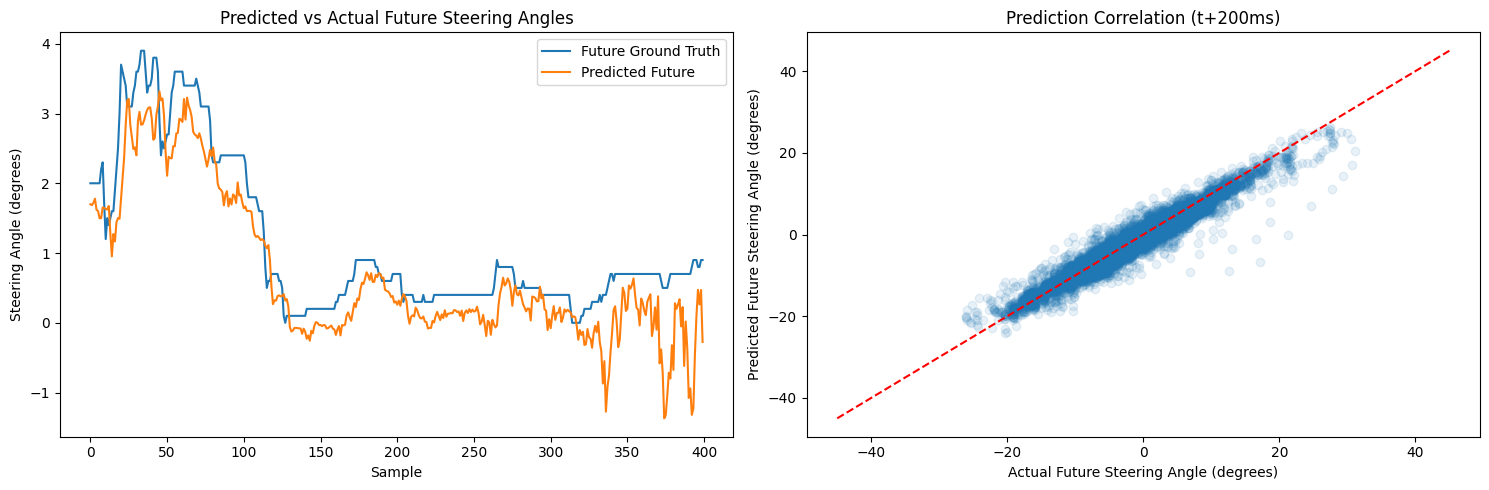


Visualizing most wrong predictions...


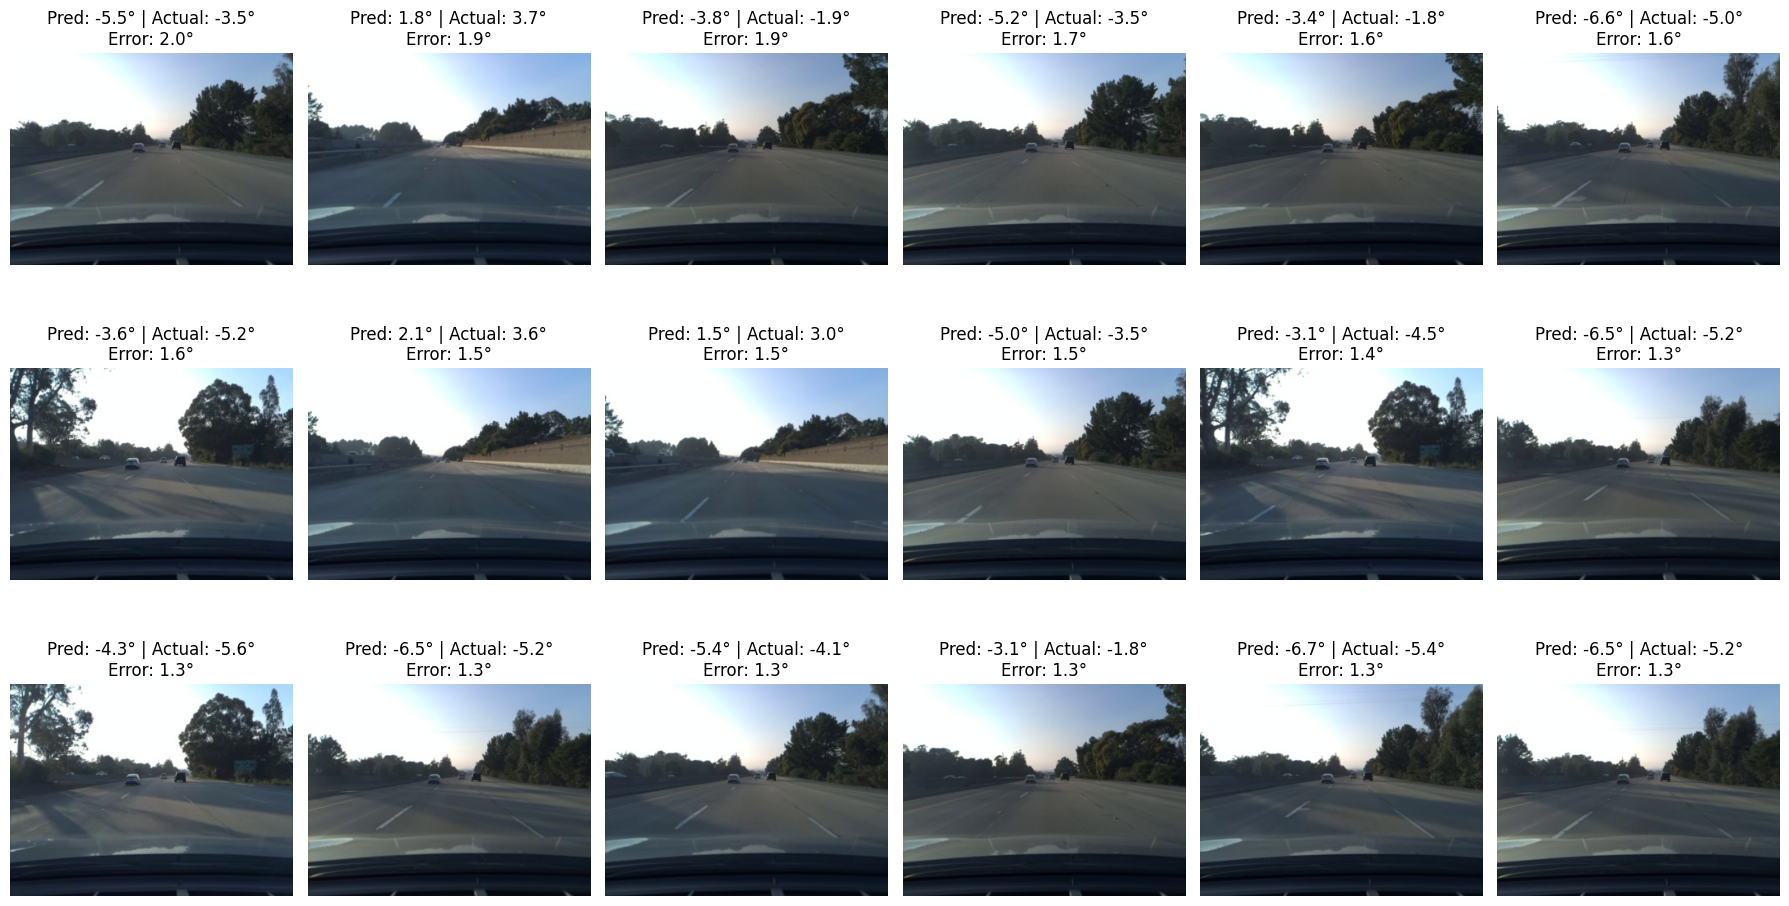

In [10]:
# Test the model
print("\nTesting the model...")
test_model(model, test_loader)

# Now visualize after training
print("\nVisualizing most wrong predictions...")
visualize_most_wrong_predictions(model, test_loader, num_worst = 18)